In [1]:
import os
import config
import platform
v1, v2, v3 = config.spark_env(platform.node())
os.environ['SPARK_VERSION'] = v1
os.environ['JAVA_HOME'] = v2
os.environ['SPARK_HOME'] = v3
import findspark
import pyspark
from pyspark.sql import SparkSession
findspark.init()
spark = SparkSession.builder.appName("emissionsdataframe").getOrCreate()
from sqlalchemy import create_engine, insert
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy import MetaData, update, Table
from sqlalchemy.orm import Session
from sqlalchemy.orm import sessionmaker
from sqlalchemy.exc import SQLAlchemyError
import pandas as pd
from pyspark.sql.types import IntegerType,BooleanType,DateType
from pyspark.sql.functions import col
from pyspark.sql import Row
from pyspark.sql.functions import array, col, explode, lit, struct, log
from pyspark.sql import DataFrame
from typing import Iterable
import numpy as np
import spark_functions
import tensorflow as tf
import keras.metrics
import pyspark.sql.functions as F
import math
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pystan
import fbprophet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
from fbprophet import Prophet
from sklearn.model_selection import train_test_split
import scipy.stats as st
rds_string = config.rds_string
engine = create_engine(f'postgresql://{rds_string}')
conn = engine.connect()
metadata = MetaData(engine)

In [2]:
india_spark, india_cols = spark_functions.merged_df("India")

In [3]:
china_spark, china_cols = spark_functions.merged_df("China")

In [4]:
germany_spark, germany_cols = spark_functions.merged_df("Germany")

In [5]:
france_spark, france_cols = spark_functions.merged_df("France")

In [6]:
mexico_spark, mexico_cols = spark_functions.merged_df("Mexico")

In [7]:
us_spark, us_cols = spark_functions.merged_df("United States")

In [8]:
def unions_spark(dfs):
    steve = len(dfs)
    df = dfs[0]
    for i in range(steve - 1):
        df = df.union(dfs[i+1])
    return df

In [9]:
dfs = [india_spark,china_spark,mexico_spark,us_spark, germany_spark, france_spark]

In [10]:
df = unions_spark(dfs)

In [31]:
df.show()

+-------+----+-----------+-------------------------------+------------------------+------------------------+-----------------------+------------------------+------------------------+-----------------------+
|country|year|        gdp|annual_co2_emissions_tonnes_log|import_trade_sum_usd_log|import_weight_sum_kg_log|import_quantity_sum_log|export_trade_sum_usd_log|export_weight_sum_kg_log|export_quantity_sum_log|
+-------+----+-----------+-------------------------------+------------------------+------------------------+-----------------------+------------------------+------------------------+-----------------------+
|  India|1990|1236.671208|              8.789988798360971|       10.56921022440232|      10.516128658135623|     10.559694467531761|      10.442299149026965|      10.584062642967528|     10.651345808860839|
|  India|1991|1265.917481|              8.817394059089324|      10.492238657775735|      10.534357164763499|     10.582458783131665|       10.43822854825847|      10.566042

In [11]:
x_cols = [
 'gdp',
 'import_trade_sum_usd_log',
 'import_weight_sum_kg_log',
 'import_quantity_sum_log',
 'export_trade_sum_usd_log',
 'export_weight_sum_kg_log',
 'export_quantity_sum_log']

In [12]:
arr = np.array(df.select(
 'gdp',
 'import_trade_sum_usd_log',
 'import_weight_sum_kg_log',
 'import_quantity_sum_log',
 'export_trade_sum_usd_log',
 'export_weight_sum_kg_log',
 'export_quantity_sum_log') \
.collect(),dtype = 'float')

In [13]:
arr2 = np.array(df.select('annual_co2_emissions_tonnes_log').collect(),dtype = 'float')

In [15]:
X_train, X_test, y_train, y_test = train_test_split(arr, arr2, test_size=0.2)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.2)

In [16]:
X_scaler = StandardScaler().fit(X_train)

In [17]:
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
X_val_scaled = X_scaler.transform(X_val)

In [18]:
model = Sequential()
model.add(Dense(units=100, activation='relu', input_dim=7))
model.add(Dense(units=100, activation='relu'))
model.add(Dense(units=100, activation='ReLU'))
model.add(Dense(units=100, activation='PReLU'))
model.add(Dense(units=100, activation='swish'))
model.add(Dense(units=1, activation='linear'))

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               800       
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10200     
_________________________________________________________________
dense_4 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 101       
Total params: 41,401
Trainable params: 41,401
Non-trainable params: 0
____________________________________________________

In [20]:
METRICS = [
      keras.metrics.MeanAbsoluteError(name='mean_absolute_error'),
      keras.metrics.MeanSquaredError(name='mean_squared_error')
]


early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='mse', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

EPOCHS = 100

In [21]:
model.compile(optimizer='adam',
              loss='mse',
              metrics=METRICS)

In [22]:
model_history = model.fit(
    X_train_scaled,
    y_train,
    epochs=EPOCHS,
    validation_data=(X_test_scaled, y_test)
)

Epoch 1/100
4/4 [==============================] - 1s 49ms/step - loss: 79.2909 - mean_absolute_error: 8.8946 - mean_squared_error: 79.2909 - val_loss: 73.2393 - val_mean_absolute_error: 8.5410 - val_mean_squared_error: 73.2393
Epoch 2/100
4/4 [==============================] - 0s 9ms/step - loss: 69.7880 - mean_absolute_error: 8.3380 - mean_squared_error: 69.7880 - val_loss: 59.0914 - val_mean_absolute_error: 7.6290 - val_mean_squared_error: 59.0914
Epoch 3/100
4/4 [==============================] - 0s 9ms/step - loss: 52.6384 - mean_absolute_error: 7.1721 - mean_squared_error: 52.6384 - val_loss: 37.4679 - val_mean_absolute_error: 5.7527 - val_mean_squared_error: 37.4679
Epoch 4/100
4/4 [==============================] - 0s 10ms/step - loss: 29.5322 - mean_absolute_error: 5.0786 - mean_squared_error: 29.5322 - val_loss: 24.0115 - val_mean_absolute_error: 4.5291 - val_mean_squared_error: 24.0115
Epoch 5/100
4/4 [==============================] - 0s 9ms/step - loss: 20.9294 - mean_abso

4/4 [==============================] - 0s 9ms/step - loss: 0.1038 - mean_absolute_error: 0.2460 - mean_squared_error: 0.1038 - val_loss: 0.1970 - val_mean_absolute_error: 0.3621 - val_mean_squared_error: 0.1970
Epoch 38/100
4/4 [==============================] - 0s 10ms/step - loss: 0.0923 - mean_absolute_error: 0.2307 - mean_squared_error: 0.0923 - val_loss: 0.1560 - val_mean_absolute_error: 0.3120 - val_mean_squared_error: 0.1560
Epoch 39/100
4/4 [==============================] - 0s 10ms/step - loss: 0.0882 - mean_absolute_error: 0.2299 - mean_squared_error: 0.0882 - val_loss: 0.1680 - val_mean_absolute_error: 0.3274 - val_mean_squared_error: 0.1680
Epoch 40/100
4/4 [==============================] - 0s 10ms/step - loss: 0.0758 - mean_absolute_error: 0.2125 - mean_squared_error: 0.0758 - val_loss: 0.1392 - val_mean_absolute_error: 0.2972 - val_mean_squared_error: 0.1392
Epoch 41/100
4/4 [==============================] - 0s 10ms/step - loss: 0.0733 - mean_absolute_error: 0.2085 - me

4/4 [==============================] - 0s 9ms/step - loss: 0.0214 - mean_absolute_error: 0.1054 - mean_squared_error: 0.0214 - val_loss: 0.0656 - val_mean_absolute_error: 0.1949 - val_mean_squared_error: 0.0656
Epoch 74/100
4/4 [==============================] - 0s 9ms/step - loss: 0.0208 - mean_absolute_error: 0.1045 - mean_squared_error: 0.0208 - val_loss: 0.0679 - val_mean_absolute_error: 0.2053 - val_mean_squared_error: 0.0679
Epoch 75/100
4/4 [==============================] - 0s 9ms/step - loss: 0.0206 - mean_absolute_error: 0.1044 - mean_squared_error: 0.0206 - val_loss: 0.0673 - val_mean_absolute_error: 0.2053 - val_mean_squared_error: 0.0673
Epoch 76/100
4/4 [==============================] - 0s 9ms/step - loss: 0.0201 - mean_absolute_error: 0.1030 - mean_squared_error: 0.0201 - val_loss: 0.0609 - val_mean_absolute_error: 0.1933 - val_mean_squared_error: 0.0609
Epoch 77/100
4/4 [==============================] - 0s 9ms/step - loss: 0.0193 - mean_absolute_error: 0.1022 - mean_s

In [27]:
predicted = model.predict(X_val_scaled)

In [28]:
actual = y_val

In [29]:
10**predicted[0][0], 10**y_val[0][0]

(1112912717.8242767, 932347358.8999999)

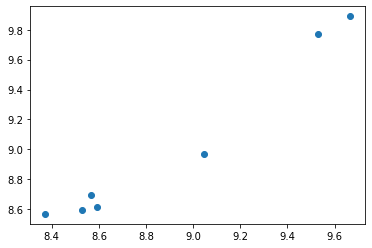

In [30]:
plt.scatter(predicted,actual)

In [32]:
dataset_norm = X_scaler.transform(arr)

In [33]:
pred = model.predict(dataset_norm)

In [34]:
act = arr2

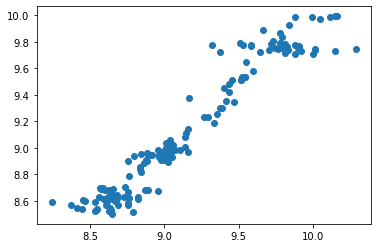

In [35]:
plt.scatter(pred, act)

In [36]:
import scipy.stats as st

In [37]:
t_len = len(pred)
predi = []
actu = []
for i in range(t_len):
    predi.append(pred[i][0].astype(float))
    actu.append(act[i][0].astype(float))
    

In [38]:
pre = np.asarray(predi,dtype=float)

In [39]:
ac = np.asarray(actu,dtype=float)

In [40]:
x_axis = pre
y_axis = ac


In [41]:
correlation = st.pearsonr(x_axis,y_axis)
(slope, intercept, rvalue, pvalue, stderr) = st.linregress(x_axis, y_axis)


In [42]:
slope

0.9355007336843416

In [43]:
slope, intercept, rvalue, pvalue, stderr

(0.9355007336843416,
 0.566735971538284,
 0.9638114407421936,
 3.57353812011869e-89,
 0.02098774605838009)

The correlation between both factors is 0.96
The linear regression equation is y = 0.93550073x + 0.57


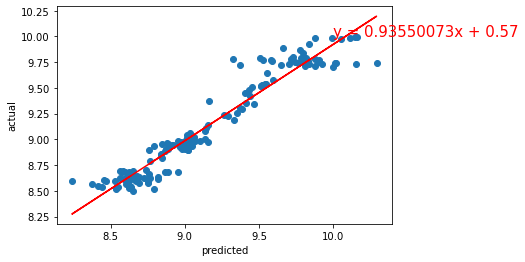

In [44]:
regress_values = x_axis * slope + intercept
line_eq = "y = " + str(round(slope,8)) + "x + " + str(round(intercept,2))
plt.scatter(x_axis,y_axis)
plt.plot(x_axis,regress_values,"r-")
plt.annotate(line_eq,(10,10),fontsize=15,color="red")
plt.xlabel('predicted')
plt.ylabel('actual')
print(f"The correlation between both factors is {round(correlation[0],2)}")
print(f'The linear regression equation is {line_eq}')
plt.show()

In [45]:
loss, mae, mse = model.evaluate(dataset_norm, act)

5/5 [==============================] - 0s 2ms/step - loss: 0.0178 - mean_absolute_error: 0.0960 - mean_squared_error: 0.0178


In [46]:
loss, mae, mse

(0.017760813236236572, 0.09596044570207596, 0.017760813236236572)

In [47]:
def make_prophet(df,periods):
    m = Prophet()
    m.fit(df)
    future = m.make_future_dataframe(periods=periods, freq='Y')
    forecast = m.predict(future)
    return (forecast, m)

def make_prophet_df(df,periods):
    m = Prophet()
    m.fit(df)
    future = m.make_future_dataframe(periods=periods, freq='Y')
    forecast = m.predict(future)
    return (forecast)

def spark_to_prophet(df, column):
    arr = np.array(df.collect())
    df = pd.DataFrame(arr, columns = column)
    ds_len = len(df)
    dates = []
    for i in range(ds_len):
        year = str(int(df['year'][i]))
        year = year + "-01-01"
        dates.append(year)
    df['year'] = dates
    return df

In [52]:

def prophetic(df, periods):
    cols = df.columns
    df = spark_to_prophet(df,cols)
    test_cols = cols[2:]
    yhat_df = pd.DataFrame()
    yhat_lower_df = pd.DataFrame()
    yhat_upper_df = pd.DataFrame()
    country_l = []
    for i in test_cols:
        future_df = pd.DataFrame()
        future_df['ds'] = df['year']
        future_df['y'] = df[i]
        df2 = make_prophet_df(future_df,periods)
        c_len = len(df2)
        try:            
            fiz = len(yhat_df['country'])
        except:
            for j in range(c_len):
                country_l.append(df['country'][0])
            yhat_df['country'] = country_l
            yhat_lower_df['country'] = country_l
            yhat_upper_df['country'] = country_l
        try:
            fiz = len(yhat_df['year'])
        except:
            yhat_df['year'] = df2['ds']
            yhat_lower_df['year'] = df2['ds']
            yhat_upper_df['year'] = df2['ds']            
        yhat_df[i] = df2['yhat']
        yhat_lower_df[i] = df2['yhat_lower']
        yhat_upper_df[i] = df2['yhat_upper']
    return (yhat_df, yhat_lower_df, yhat_upper_df, df)


In [53]:
yhat_df, yhat_lower_df, yhat_upper_df, us_pd_df = prophetic(us_spark, 10)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 19.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 19.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 19.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run

In [65]:
y_set = []
y_filt = []
set_len = len(yhat_df)
filt_len = len(df)
for i in range(set_len):
    y_set.append(yhat_df["year"][i])
for i in range(filt_len):
    y_filt.append(df['year'][i])

TypeError: object of type 'DataFrame' has no len()

In [ ]:
df.year.value_counts()

In [ ]:
df.count()

In [62]:
yhat_df["year"].isin(df['year'])    

TypeError: unhashable type: 'Column'

In [60]:
yhat_df[~yhat_df["year"].isin(df['year'])]

TypeError: unhashable type: 'Column'

In [57]:
df_model_pred = yhat_df[~yhat_df["year"].contains(df['year'])]

AttributeError: 'Series' object has no attribute 'contains'

In [55]:
df_model_pred = yhat_df.loc[yhat_df['year'] not in df['year']]

ValueError: Cannot apply 'in' operator against a column: please use 'contains' in a string column or 'array_contains' function for an array column.

In [ ]:
df_tst = spark_to_prophet(us_spark,us_cols)

In [ ]:
test_cols = us_cols[2:]

In [ ]:
# tst_dict = {'yhat':[],'yhat_lower':[],'yhat_upper':[]}
yhat_df = pd.DataFrame()
yhat_lower_df = pd.DataFrame()
yhat_upper_df = pd.DataFrame()
for i in test_cols:
    future_df['ds'] = df_tst['year']
    future_df['y'] = df_tst[i]
    df = make_prophet_df(future_df,10)
    yhat_df[i] = df['yhat']
    yhat_lower_df[i] = df['yhat_lower']
    yhat_upper_df[i] = df['yhat_upper']
yhat_df['year'] = df['ds']
yhat_lower_df['year'] = df['ds']
yhat_upper_df['year'] = df['ds']

In [ ]:
us_test1, fb_model = make_prophet(us_pd_df2,10)

In [ ]:
fig2 = fb_model.plot(us_test1)

In [ ]:
e_m = Prophet()
e_m.fit(us_prophet_df_f)
future = e_m.make_future_dataframe(periods=10, freq='Y')
forecast = e_m.predict(future)
fig1 = e_m.plot(forecast)

In [ ]:
forecast

In [ ]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]


In [ ]:
plt.plot(forecast['ds'],forecast['yhat'])
plt.plot(forecast['ds'],forecast['yhat_upper'])
plt.plot(forecast['ds'],forecast['yhat_lower'])
plt.plot(forecast['ds'],forecast['trend'])